# BEMB Demo: Simulation Studies.

> Author: Tianyu Du (tianyudu@stanford.edu)

This notebook contains replication materials for the simulation studies in the BEMB paper;

Before running this notebook, you should create a folder called, to save simulation results (e.g., figures). Please modify the `OUTPUT_DIR` variable below to point to the folder you just created.

In [1]:
import os
OUTPUT_DIR = "./paper_demo_simulation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Setup.

In [2]:
# Standard library imports
import random
from typing import List

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.manifold import TSNE
from torch_choice.data import ChoiceDataset
from tqdm import tqdm

# Local imports
from bemb.model import LitBEMBFlex

In [3]:
# Fix Random Seeds for Reproducibility.
random.seed(1234)
np.random.seed(1234)
torch.random.manual_seed(1234)

In [4]:
# Please note that `mps` (apple silicon gpus) is not fully supported by PyTorch; therefore, you would need to use `cpu` device on Mac.
if torch.cuda.is_available():
    DEVICE = "cuda"
    try:
        # control the precision of GPU-based operations.
        torch.set_float32_matmul_precision("high")
    except:
        pass
else:
    DEVICE = "cpu"
print(f"Using {DEVICE} device with torch version {torch.__version__} and name {torch.cuda.get_device_name(DEVICE)}")

Using cuda device with torch version 2.5.1+cu124 and name NVIDIA GeForce RTX 3090


In [5]:
# control the quality of figures. Use 75 for preview, use 300 for publication.
# using a larger DPI will increase the file size of the figure and the time to render the figure.
DPI = 300

In [6]:
# configure the size of simulation.
num_users = 1_500  # 1500 users in the dataset.
num_items = 50  # 50 items to choose from.
num_sessions = 10  # 10 sessions; sessions are used only in simulation 4.
data_size = 50_000  # 10,000 choice records.

# New Simulation Studies introduced in 2025 Revision.

Preview of simulated purchase records:
   session  user  item  user_cluster  item_cluster       M_ui    f_M_ui  \
0       15  1117    45            12             0  10.133041  2.409917   
1        8   706    28            12             2  15.248161  2.787980   
2       15   213    31            11             2  10.572020  2.448590   
3        6   261    32             8             1  10.542050  2.445997   
4        5  1408    31             2             2   8.842532  2.286713   

       P_uis      U_uis  
0   9.766105   6.635065  
1  13.987943  10.897690  
2  10.324109   5.250709  
3  11.127061   5.980675  
4  18.620900   1.600911  


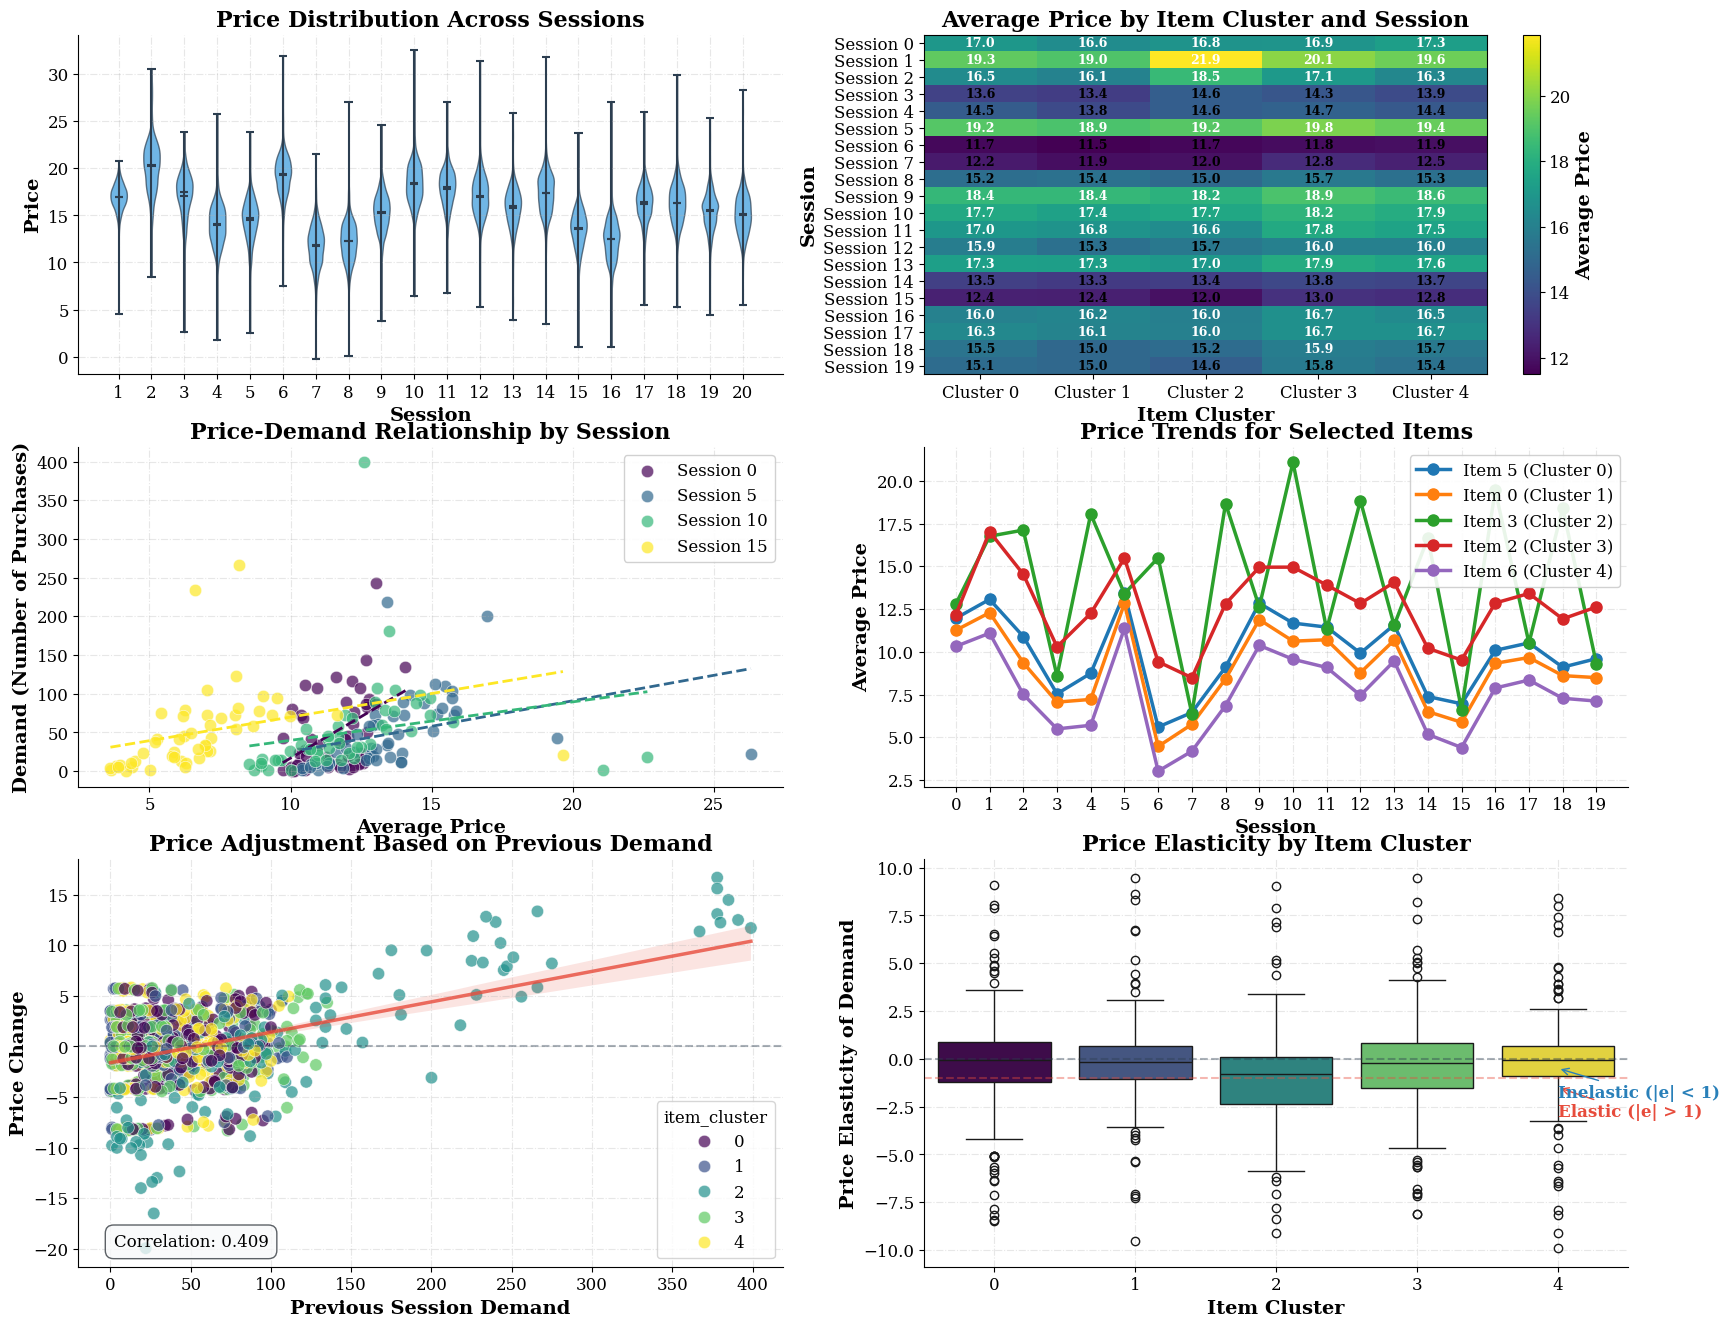

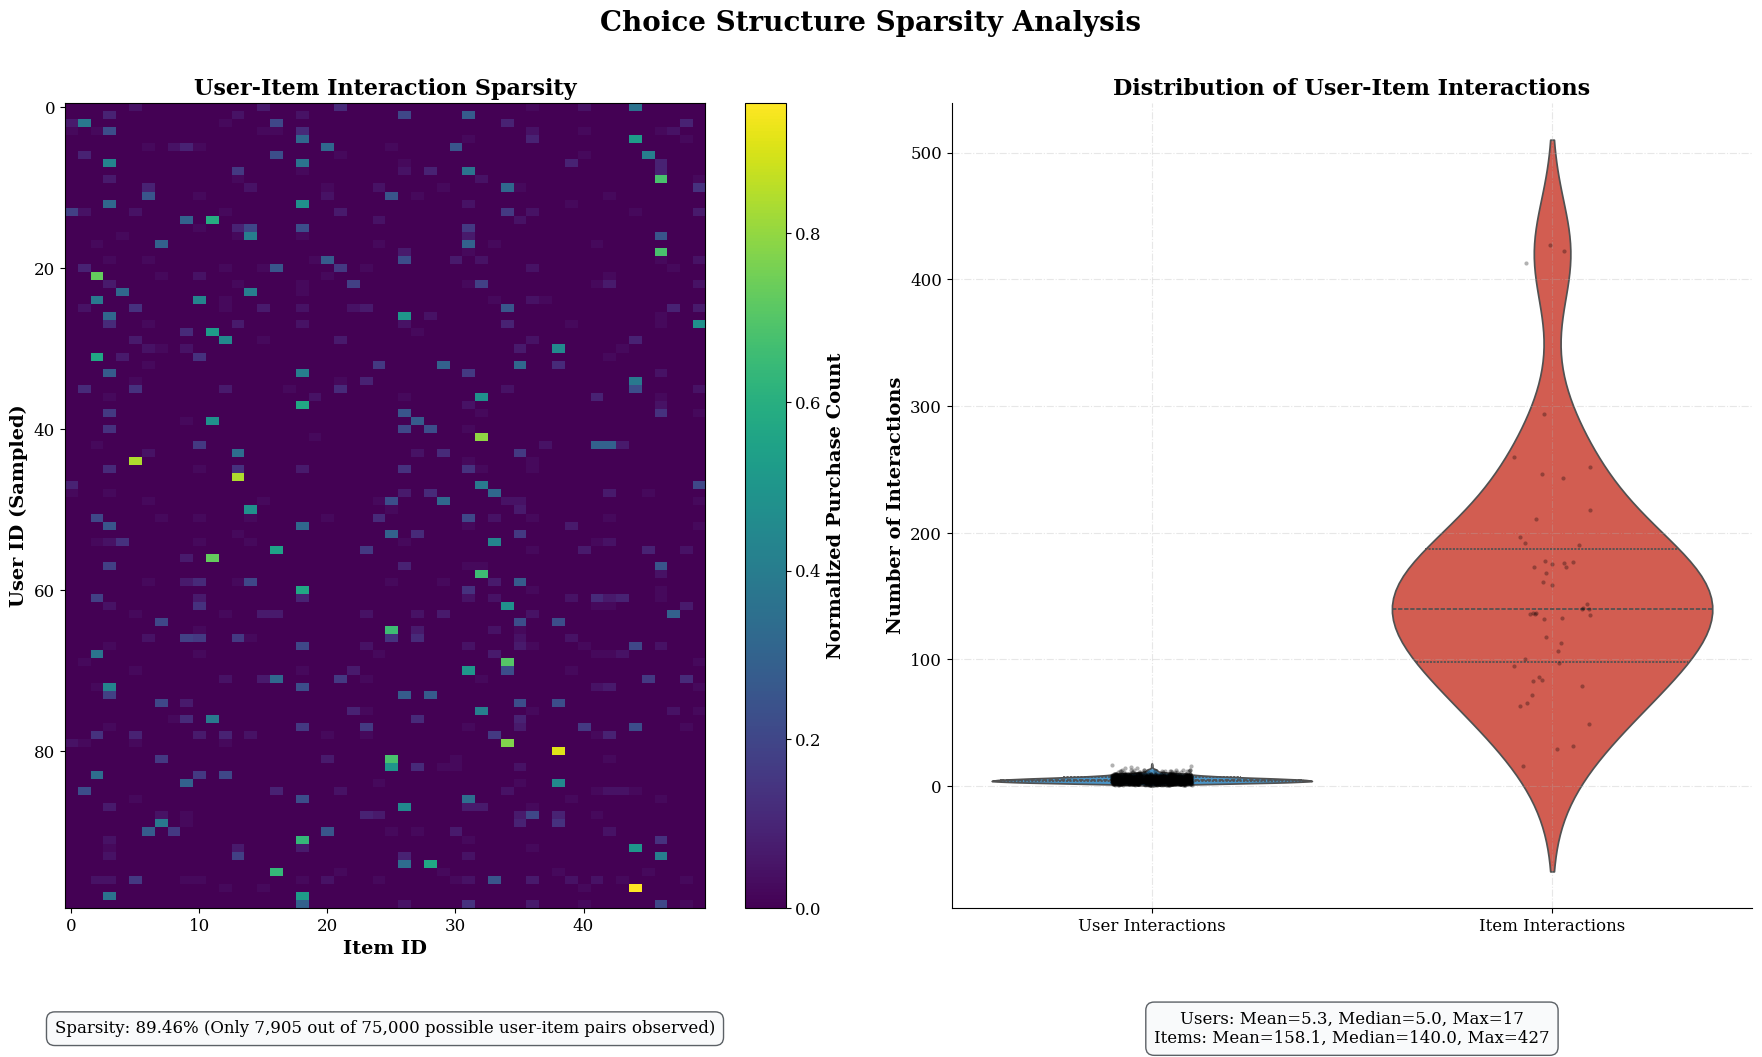

<Figure size 640x480 with 0 Axes>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

# -------------------------------
# Environment and Simulation Parameters
# -------------------------------
num_users = 1_500   # 1500 users in the dataset.
num_items = 50      # 50 items to choose from.
num_sessions = 20   # 20 different shopping occasions
data_size = 50_000  # 50,000 purchase records.

# Clustering parameters (updated)
K_u = 15       # number of user clusters
K_i = 5        # number of item clusters
R = 50         # latent dimension

# Variance parameters for clusters and within-cluster noise
sigma_cluster_u = 1.0   # std dev for user cluster means
sigma_user = 0.5        # within-user-cluster noise std dev for latent factors
sigma_cluster_i = 1.0   # std dev for item cluster means
sigma_item = 0.5        # within-item-cluster noise std dev for latent factors

# Personalized offer (treatment) generation parameters
delta_0 = 10.0      # baseline offer level
delta_1 = 2.0       # scaling factor for effect of latent interaction
sigma_P = 1.0       # noise std dev for the offer
sigma_P_session = 2.0  # session-specific variation in base offer

# Demand-driven price adjustment parameters
demand_effect = 2.0    # coefficient for how much previous session demand affects price
demand_noise = 0.3     # random noise in the demand-price relationship

# Fixed effects for users and items
sigma_alpha = 1.0   # user fixed effect std dev
sigma_beta = 1.0    # item fixed effect std dev

# Utility generation parameters
direct_pref_weight = 1.0  # direct weight of user-item preference match
gamma = -0.5        # price sensitivity coefficient (negative: higher price reduces utility)
sigma_U = 1.0       # noise std dev for the utility

# Set seed for reproducibility
np.random.seed(42)

# ----------------------------------------------------------------------------------------------------------------------
# 1. Generate User and Item Latent Factors with Clustering
# ----------------------------------------------------------------------------------------------------------------------

# For users:
user_clusters = np.random.choice(K_u, size=num_users)
cluster_means_users = np.random.normal(0, sigma_cluster_u, size=(K_u, R))
theta = np.array([
    cluster_means_users[user_clusters[u]] + np.random.normal(0, sigma_user, size=R)
    for u in range(num_users)
])

# For items:
item_clusters = np.random.choice(K_i, size=num_items)
cluster_means_items = np.random.normal(0, sigma_cluster_i, size=(K_i, R))
eta = np.array([
    cluster_means_items[item_clusters[i]] + np.random.normal(0, sigma_item, size=R)
    for i in range(num_items)
])

# ----------------------------------------------------------------------------------------------------------------------
# 2. Compute the Base User-Item Interaction Matrix
# ----------------------------------------------------------------------------------------------------------------------
# Compute M_{ui} = <theta_u, eta_i>
M = theta.dot(eta.T)  # shape: (num_users, num_items)

# ----------------------------------------------------------------------------------------------------------------------
# 3. Generate Fixed Effects for Users and Items
# ----------------------------------------------------------------------------------------------------------------------
alpha = np.random.normal(0, sigma_alpha, size=num_users)  # user fixed effects
beta = np.random.normal(0, sigma_beta, size=num_items)    # item fixed effects


# ----------------------------------------------------------------------------------------------------------------------
# 4. Generate the Personalized Offer P_{uis} as a Nonlinear Function of M_{ui} and Previous Demand
# ----------------------------------------------------------------------------------------------------------------------
# Define a nonlinear transformation function f(x) = sign(x) * log(1 + |x|)
def nonlinear_transform(x):
    return np.sign(x) * np.log(1 + np.abs(x))

# The non-linearly transformed user-item interaction matrix.
F_M = nonlinear_transform(M)

# Generate session-specific personalized offers
P = np.zeros((num_sessions, num_users, num_items))
# First session prices are based only on base parameters (no previous demand)
s = 0
session_delta_0 = delta_0 + np.random.normal(0, sigma_P_session)
# The base-price is a linear function of the non-linearly transformed user-item interaction matrix.
P[s] = session_delta_0 + delta_1 * F_M + np.random.normal(0, sigma_P, size=(num_users, num_items))

# ----------------------------------------------------------------------------------------------------------------------
# 5. Generate the Utility Matrix U
# ----------------------------------------------------------------------------------------------------------------------
# U_{uis} = alpha_u + beta_i + direct_pref_weight * M_{ui} + gamma * P_{uis} + noise
U = np.zeros((num_sessions, num_users, num_items))

# For subsequent sessions, generate prices that also depend on previous session demand
for s in range(num_sessions):
    U[s] = (alpha[:, np.newaxis] + beta[np.newaxis, :]
            + direct_pref_weight * M  # Direct inclusion of user-item preference match
            + gamma * P[s]            # Price effect varies by session
            + np.random.normal(0, sigma_U, size=(num_users, num_items)))
    # Base offer level varies by session (representing different time periods)
    session_delta_0 = delta_0 + np.random.normal(0, sigma_P_session)

    # Calculate the expected demand for each item in the current session
    # Calculate expected demand and standardize it (zero mean, unit variance)
    expected_demand = np.sum(np.exp(U[s]) / np.sum(np.exp(U[s]), axis=1, keepdims=True), axis=0)  # shape: (num_items,)
    expected_demand = (expected_demand - np.mean(expected_demand)) / np.std(expected_demand)  # standardize

    # Update the price for each item based on the expected demand in the next session, if it is not the last session
    if s < num_sessions - 1:
        price_update = demand_effect * expected_demand
        P[s+1] = session_delta_0 + delta_1 * F_M + price_update[np.newaxis, :] + np.random.normal(0, sigma_P, size=(num_users, num_items))


# ----------------------------------------------------------------------------------------------------------------------
# 6. Sample Purchase Records via a Softmax over U and Track Demand
# ----------------------------------------------------------------------------------------------------------------------
def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / np.sum(ex)

# Sample sessions and users
sampled_sessions = np.random.choice(num_sessions, size=data_size)
sampled_users = np.random.choice(num_users, size=data_size)
sampled_items = np.empty(data_size, dtype=int)

# For each observation, sample an item based on the utility
for idx in range(data_size):
    s = sampled_sessions[idx]
    u = sampled_users[idx]
    probs = softmax(U[s, u, :])
    item = np.random.choice(num_items, p=probs)
    sampled_items[idx] = item

# Create records dataframe with all relevant information
records = {
    'session': sampled_sessions,
    'user': sampled_users,
    'item': sampled_items,
    'user_cluster': user_clusters[sampled_users],
    'item_cluster': item_clusters[sampled_items],
    'M_ui': M[sampled_users, sampled_items],
    'f_M_ui': F_M[sampled_users, sampled_items],
    'P_uis': np.array([P[s, u, i] for s, u, i in zip(sampled_sessions, sampled_users, sampled_items)]),
    'U_uis': np.array([U[s, u, i] for s, u, i in zip(sampled_sessions, sampled_users, sampled_items)])
}
df_purchases = pd.DataFrame(records)

print("Preview of simulated purchase records:")
print(df_purchases.head())

# Calculate purchases per session and item
purchases_per_session = np.zeros((num_sessions, num_items))
for s in range(num_sessions):
    for i in range(num_items):
        purchases_per_session[s, i] = np.sum((sampled_sessions == s) & (sampled_items == i))

# -------------------------------
# Visualize Price Dynamics
# -------------------------------

# Set professional plotting style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Create a figure with multiple subplots for comprehensive price dynamics visualization
fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.2])

# 1. Price Distribution by Session
ax1 = fig.add_subplot(gs[0, 0])

# Create violin plots for price distribution across sessions
session_prices = [df_purchases[df_purchases['session'] == s]['P_uis'] for s in range(num_sessions)]
violin_parts = ax1.violinplot(session_prices, showmeans=True, showmedians=True)

# Customize violin plot appearance
for pc in violin_parts['bodies']:
    pc.set_facecolor('#3498db')
    pc.set_edgecolor('#2c3e50')
    pc.set_alpha(0.7)

for partname in ['cbars', 'cmins', 'cmaxes', 'cmeans', 'cmedians']:
    if partname in violin_parts:
        vp = violin_parts[partname]
        vp.set_edgecolor('#2c3e50')
        vp.set_linewidth(1.5)

# Add styling
ax1.set_xlabel('Session', fontweight='bold')
ax1.set_ylabel('Price', fontweight='bold')
ax1.set_title('Price Distribution Across Sessions', fontsize=16, fontweight='bold')
ax1.set_xticks(np.arange(1, num_sessions+1))
ax1.grid(True, alpha=0.3, linestyle='-.')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 2. Price Heatmap by Item Cluster and Session
ax2 = fig.add_subplot(gs[0, 1])

# Calculate average price per session and item cluster
price_by_cluster_session = np.zeros((num_sessions, K_i))
for s in range(num_sessions):
    for ic in range(K_i):
        session_cluster_prices = df_purchases[(df_purchases['session'] == s) &
                                             (df_purchases['item_cluster'] == ic)]['P_uis']
        if len(session_cluster_prices) > 0:
            price_by_cluster_session[s, ic] = session_cluster_prices.mean()

# Create heatmap
im = ax2.imshow(price_by_cluster_session, cmap='viridis', aspect='auto', interpolation='nearest')
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('Average Price', fontweight='bold')

# Add styling
ax2.set_xlabel('Item Cluster', fontweight='bold')
ax2.set_ylabel('Session', fontweight='bold')
ax2.set_title('Average Price by Item Cluster and Session', fontsize=16, fontweight='bold')
ax2.set_xticks(np.arange(K_i))
ax2.set_yticks(np.arange(num_sessions))
ax2.set_xticklabels([f'Cluster {i}' for i in range(K_i)])
ax2.set_yticklabels([f'Session {i}' for i in range(num_sessions)])

# Add text annotations with actual values
for s in range(num_sessions):
    for ic in range(K_i):
        text = ax2.text(ic, s, f"{price_by_cluster_session[s, ic]:.1f}",
                       ha="center", va="center",
                       color="white" if price_by_cluster_session[s, ic] > np.mean(price_by_cluster_session) else "black",
                       fontweight='bold', fontsize=9)

# 3. Price vs. Demand Scatter Plot
ax3 = fig.add_subplot(gs[1, 0])

# Calculate average price and demand for each item in each session
price_demand_data = []
for s in range(num_sessions):
    for i in range(num_items):
        avg_price = np.mean(P[s, :, i])
        demand = purchases_per_session[s, i]
        price_demand_data.append({
            'session': s,
            'item': i,
            'item_cluster': item_clusters[i],
            'avg_price': avg_price,
            'demand': demand
        })
price_demand_df = pd.DataFrame(price_demand_data)

# Create scatter plot with regression line for each session
sessions_to_show = [0, 5, 10, 15]  # Show only a few sessions for clarity
colors = plt.cm.viridis(np.linspace(0, 1, len(sessions_to_show)))

for idx, s in enumerate(sessions_to_show):
    session_data = price_demand_df[price_demand_df['session'] == s]
    ax3.scatter(
        session_data['avg_price'],
        session_data['demand'],
        s=80,
        alpha=0.7,
        color=colors[idx],
        edgecolor='w',
        linewidth=0.5,
        label=f'Session {s}'
    )

    # Add regression line
    if len(session_data) > 1:  # Need at least 2 points for regression
        x = session_data['avg_price']
        y = session_data['demand']
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax3.plot(
            np.sort(x),
            p(np.sort(x)),
            '--',
            color=colors[idx],
            linewidth=2
        )

# Add styling
ax3.set_xlabel('Average Price', fontweight='bold')
ax3.set_ylabel('Demand (Number of Purchases)', fontweight='bold')
ax3.set_title('Price-Demand Relationship by Session', fontsize=16, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='-.')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.legend(loc='best', frameon=True, framealpha=0.9)

# 4. Price Trend for Selected Items
ax4 = fig.add_subplot(gs[1, 1])

# Select a few items from different clusters
selected_items = []
for ic in range(min(K_i, 5)):  # Select one item from each cluster (up to 5)
    cluster_items = np.where(item_clusters == ic)[0]
    if len(cluster_items) > 0:
        selected_items.append(cluster_items[0])

# Calculate average price for each selected item across sessions
for item in selected_items:
    item_prices = [np.mean(P[s, :, item]) for s in range(num_sessions)]
    ax4.plot(
        range(num_sessions),
        item_prices,
        'o-',
        linewidth=2.5,
        markersize=8,
        label=f'Item {item} (Cluster {item_clusters[item]})'
    )

# Add styling
ax4.set_xlabel('Session', fontweight='bold')
ax4.set_ylabel('Average Price', fontweight='bold')
ax4.set_title('Price Trends for Selected Items', fontsize=16, fontweight='bold')
ax4.set_xticks(np.arange(num_sessions))
ax4.grid(True, alpha=0.3, linestyle='-.')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.legend(loc='best', frameon=True, framealpha=0.9)

# 5. Price Change vs Previous Demand
ax5 = fig.add_subplot(gs[2, 0])

# Calculate price changes and previous demand
price_change_data = []
for s in range(1, num_sessions):  # Start from session 1 to calculate changes
    for i in range(num_items):
        prev_price = np.mean(P[s-1, :, i])
        curr_price = np.mean(P[s, :, i])
        price_change = curr_price - prev_price
        prev_demand = purchases_per_session[s-1, i]

        price_change_data.append({
            'session': s,
            'item': i,
            'item_cluster': item_clusters[i],
            'prev_demand': prev_demand,
            'price_change': price_change
        })
price_change_df = pd.DataFrame(price_change_data)

# Create scatter plot with regression line
sns.scatterplot(
    data=price_change_df,
    x='prev_demand',
    y='price_change',
    hue='item_cluster',
    palette='viridis',
    s=80,
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5,
    ax=ax5
)

# Add regression line
sns.regplot(
    data=price_change_df,
    x='prev_demand',
    y='price_change',
    scatter=False,
    line_kws={"color":"#e74c3c", "alpha":0.8, "lw":2.5, "ls":"-"},
    ci=95,
    ax=ax5
)

# Add styling
ax5.set_xlabel('Previous Session Demand', fontweight='bold')
ax5.set_ylabel('Price Change', fontweight='bold')
ax5.set_title('Price Adjustment Based on Previous Demand', fontsize=16, fontweight='bold')
ax5.grid(True, alpha=0.3, linestyle='-.')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.axhline(y=0, color='#2c3e50', linestyle='--', alpha=0.4, linewidth=1.5)

# Calculate and display correlation
corr = price_change_df['prev_demand'].corr(price_change_df['price_change'])
ax5.annotate(f"Correlation: {corr:.3f}",
             xy=(0.05, 0.05),
             xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="#f8f9fa", ec="#343a40", alpha=0.8),
             fontsize=12)

# 6. Price Elasticity Analysis
ax6 = fig.add_subplot(gs[2, 1])

# Calculate price elasticity for each item between consecutive sessions
elasticity_data = []
for s in range(1, num_sessions):
    for i in range(num_items):
        prev_price = np.mean(P[s-1, :, i])
        curr_price = np.mean(P[s, :, i])
        prev_demand = purchases_per_session[s-1, i]
        curr_demand = purchases_per_session[s, i]

        # Calculate percentage changes
        if prev_price > 0 and prev_demand > 0:
            price_pct_change = (curr_price - prev_price) / prev_price
            demand_pct_change = (curr_demand - prev_demand) / prev_demand

            # Calculate elasticity (avoid division by zero)
            if abs(price_pct_change) > 0.001:
                elasticity = demand_pct_change / price_pct_change
            else:
                elasticity = 0

            elasticity_data.append({
                'session': s,
                'item': i,
                'item_cluster': item_clusters[i],
                'price_pct_change': price_pct_change,
                'demand_pct_change': demand_pct_change,
                'elasticity': elasticity
            })
elasticity_df = pd.DataFrame(elasticity_data)

# Filter out extreme elasticity values for better visualization
elasticity_df = elasticity_df[elasticity_df['elasticity'].between(-10, 10)]

# Create boxplot of elasticity by item cluster
sns.boxplot(
    data=elasticity_df,
    x='item_cluster',
    y='elasticity',
    hue='item_cluster',
    palette='viridis',
    legend=False,
    ax=ax6
)

# Add styling
ax6.set_xlabel('Item Cluster', fontweight='bold')
ax6.set_ylabel('Price Elasticity of Demand', fontweight='bold')
ax6.set_title('Price Elasticity by Item Cluster', fontsize=16, fontweight='bold')
ax6.grid(True, alpha=0.3, linestyle='-.')
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)
ax6.axhline(y=0, color='#2c3e50', linestyle='--', alpha=0.4, linewidth=1.5)
ax6.axhline(y=-1, color='#e74c3c', linestyle='--', alpha=0.4, linewidth=1.5)

# Add annotations for elasticity interpretation
ax6.annotate("Elastic (|e| > 1)",
             xy=(K_i-1, -1.5),
             xytext=(K_i-1, -3),
             arrowprops=dict(arrowstyle="->", color="#e74c3c"),
             color="#e74c3c",
             fontweight='bold')

ax6.annotate("Inelastic (|e| < 1)",
             xy=(K_i-1, -0.5),
             xytext=(K_i-1, -2),
             arrowprops=dict(arrowstyle="->", color="#2980b9"),
             color="#2980b9",
             fontweight='bold')

# Create a new figure for choice structure sparsity visualization
plt.figure(figsize=(18, 10))
gs_sparsity = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# 1. User-Item Interaction Heatmap
ax_heatmap = plt.subplot(gs_sparsity[0])

# Create a matrix to track which user-item pairs appear in the dataset
user_item_matrix = np.zeros((num_users, num_items))
for _, row in df_purchases.iterrows():
    # Convert to integers to avoid IndexError
    user = int(row['user'])
    item = int(row['item'])
    user_item_matrix[user, item] += 1

# Normalize by the maximum count for better visualization
max_count = user_item_matrix.max()
if max_count > 0:
    user_item_matrix = user_item_matrix / max_count

# Sample a subset of users and items if the matrix is too large
sample_size = min(100, num_users)  # Sample at most 100 users for visibility
sampled_users_idx = np.random.choice(num_users, size=sample_size, replace=False)
sampled_users_idx.sort()  # Sort for better visualization

# Create heatmap
im = ax_heatmap.imshow(
    user_item_matrix[sampled_users_idx, :],
    cmap='viridis',
    aspect='auto',
    interpolation='nearest'
)

# Add colorbar
cbar = plt.colorbar(im, ax=ax_heatmap)
cbar.set_label('Normalized Purchase Count', fontweight='bold')

# Add styling
ax_heatmap.set_xlabel('Item ID', fontweight='bold')
ax_heatmap.set_ylabel('User ID (Sampled)', fontweight='bold')
ax_heatmap.set_title('User-Item Interaction Sparsity', fontsize=16, fontweight='bold')

# Calculate and display sparsity metrics
total_possible_interactions = num_users * num_items
actual_interactions = np.count_nonzero(user_item_matrix)
sparsity_percentage = 100 * (1 - actual_interactions / total_possible_interactions)

ax_heatmap.text(
    0.5, -0.15,
    f"Sparsity: {sparsity_percentage:.2f}% (Only {actual_interactions:,} out of {total_possible_interactions:,} possible user-item pairs observed)",
    transform=ax_heatmap.transAxes,
    ha='center',
    va='center',
    bbox=dict(boxstyle="round,pad=0.5", fc="#f8f9fa", ec="#343a40", alpha=0.8),
    fontsize=12
)

# 2. Distribution of Interactions
ax_dist = plt.subplot(gs_sparsity[1])

# Calculate statistics
user_interaction_counts = np.sum(user_item_matrix > 0, axis=1)  # Number of unique items per user
item_interaction_counts = np.sum(user_item_matrix > 0, axis=0)  # Number of unique users per item

# Create separate DataFrames for user and item interactions to avoid length mismatch
user_df = pd.DataFrame({'Type': 'User Interactions', 'Count': user_interaction_counts})
item_df = pd.DataFrame({'Type': 'Item Interactions', 'Count': item_interaction_counts})
interaction_df_melted = pd.concat([user_df, item_df], ignore_index=True)

# Create violin plots
sns.violinplot(
    data=interaction_df_melted,
    x='Type',
    y='Count',
    hue='Type',
    palette=['#3498db', '#e74c3c'],
    inner='quartile',
    legend=False,
    ax=ax_dist
)

# Add individual data points
sns.stripplot(
    data=interaction_df_melted,
    x='Type',
    y='Count',
    color='black',
    size=3,
    alpha=0.3,
    jitter=True,
    ax=ax_dist
)

# Add styling
ax_dist.set_xlabel('', fontweight='bold')
ax_dist.set_ylabel('Number of Interactions', fontweight='bold')
ax_dist.set_title('Distribution of User-Item Interactions', fontsize=16, fontweight='bold')
ax_dist.grid(True, alpha=0.3, linestyle='-.')
ax_dist.spines['top'].set_visible(False)
ax_dist.spines['right'].set_visible(False)

# Add summary statistics
user_stats = f"Users: Mean={user_interaction_counts.mean():.1f}, Median={np.median(user_interaction_counts):.1f}, Max={user_interaction_counts.max():.0f}"
item_stats = f"Items: Mean={item_interaction_counts.mean():.1f}, Median={np.median(item_interaction_counts):.1f}, Max={item_interaction_counts.max():.0f}"

ax_dist.text(
    0.5, -0.15,
    f"{user_stats}\n{item_stats}",
    transform=ax_dist.transAxes,
    ha='center',
    va='center',
    bbox=dict(boxstyle="round,pad=0.5", fc="#f8f9fa", ec="#343a40", alpha=0.8),
    fontsize=12
)

plt.tight_layout()
plt.suptitle('Choice Structure Sparsity Analysis', fontsize=20, fontweight='bold', y=1.05)
plt.show()

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3)

# Add a title for the entire figure
fig.suptitle('Dynamic Pricing Simulation: Comprehensive Price Dynamics Analysis',
             fontsize=22, fontweight='bold', y=0.98)
plt.subplots_adjust(top=0.94)

plt.show()


In [8]:
# Create a ChoiceDataset using only the df_purchases DataFrame
import torch
from torch_choice.data import ChoiceDataset

# Convert user and item indices to PyTorch tensors
user_index = torch.LongTensor(df_purchases['user'].values)
item_index = torch.LongTensor(df_purchases['item'].values)

# Create session indices (one session per purchase record)
session_index = torch.arange(len(df_purchases), dtype=torch.long)

# Extract the purchase-specific features from df_purchases
user_cluster = torch.LongTensor(df_purchases['user_cluster'].values)
item_cluster = torch.LongTensor(df_purchases['item_cluster'].values)
M_ui = torch.FloatTensor(df_purchases['M_ui'].values)
f_M_ui = torch.FloatTensor(df_purchases['f_M_ui'].values)
P_uis = torch.FloatTensor(df_purchases['P_uis'].values)  # Using P_uis instead of P_ui
U_uis = torch.FloatTensor(df_purchases['U_uis'].values)  # Using U_uis

# Create a tensor containing all the user-item pair features
usersessionitem_obs = torch.stack([
    user_cluster.float(),
    item_cluster.float(),
    M_ui,
    f_M_ui,
    P_uis,  # Using P_uis instead of P_ui
    U_uis
], dim=1)

# Create the ChoiceDataset with explicit user, item, and session counts
dataset_nonlinear = ChoiceDataset(
    user_index=user_index,
    item_index=item_index,
    session_index=session_index,
    # Explicitly specify the number of users, items, and sessions
    num_users=num_users,
    num_items=num_items,
    num_sessions=data_size,  # Since we have one session per purchase record
    # All items are available
    item_availability=None,
    # Add the usersessionitem observation tensor
    usersessionitem_obs=usersessionitem_obs
)

print(dataset_nonlinear)

# Split into train, validation, and test sets
def split_dataset_into_train_val_test(D):
    # Split dataset into train, val, test
    idx = np.random.permutation(len(D))
    train_size = int(0.8 * len(D))
    val_size = int(0.1 * len(D))
    train_idx = idx[:train_size]
    val_idx = idx[train_size: train_size + val_size]
    test_idx = idx[train_size + val_size:]

    dataset_list = [D[train_idx], D[val_idx], D[test_idx]]
    return dataset_list

# Split the dataset and move to appropriate device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

dataset_list = split_dataset_into_train_val_test(dataset_nonlinear)
dataset_list = [d.to(DEVICE) for d in dataset_list]

print(f"Training set: {len(dataset_list[0])} samples")
print(f"Validation set: {len(dataset_list[1])} samples")
print(f"Test set: {len(dataset_list[2])} samples")

ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[50000], user_index=[50000], session_index=[50000], item_availability=[], usersessionitem_obs=[50000, 6], device=cpu)
Training set: 40000 samples
Validation set: 5000 samples
Test set: 5000 samples


Basic statistics for item choices:
Total number of purchases: 50000
Number of unique items chosen: 50 out of 50 possible items
Average purchases per item: 1000.00
Minimum purchases for an item: 24
Maximum purchases for an item: 3866


Top 10 most frequently chosen items:
    Count  Percentage
18   3866       7.732
31   2663       5.326
3    2363       4.726
26   2212       4.424
2    1991       3.982
10   1977       3.954
13   1818       3.636
38   1771       3.542
34   1757       3.514
47   1679       3.358


Top 10 least frequently chosen items:
    Count  Percentage
17     24       0.048
19     47       0.094
37     58       0.116
30    101       0.202
22    126       0.252
8     171       0.342
24    188       0.376
29    251       0.502
43    253       0.506
20    258       0.516




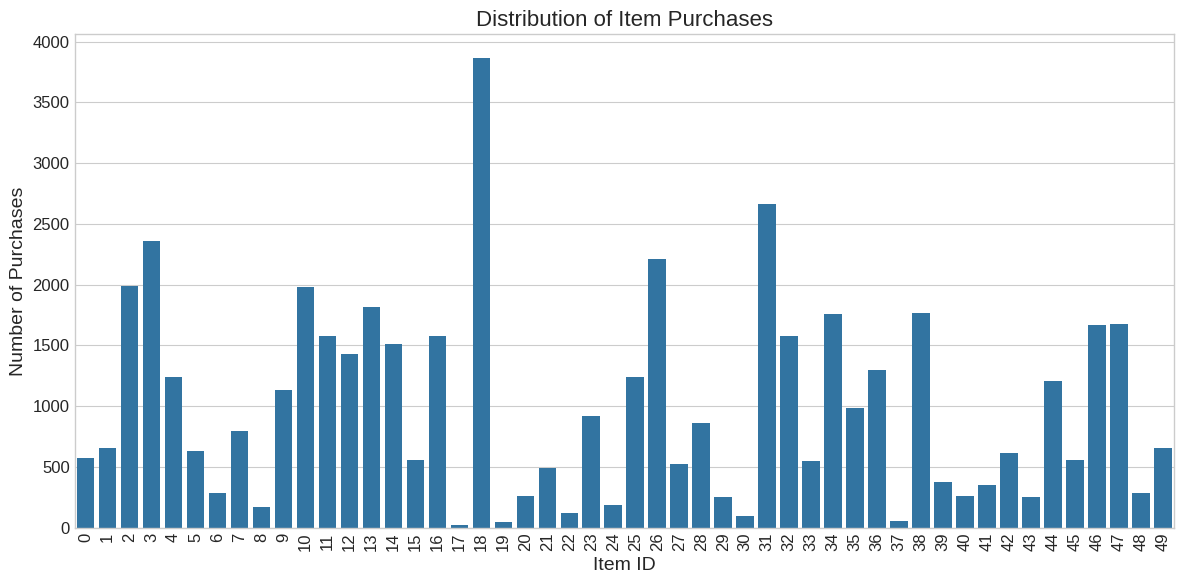

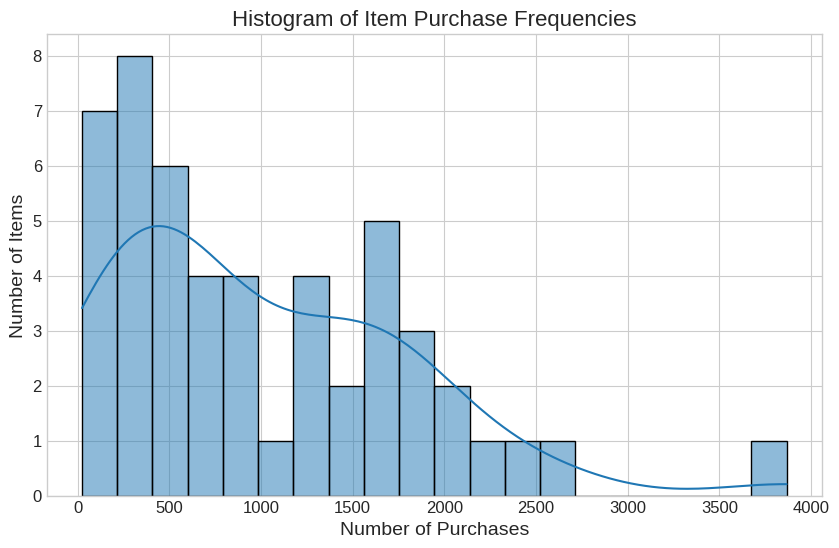

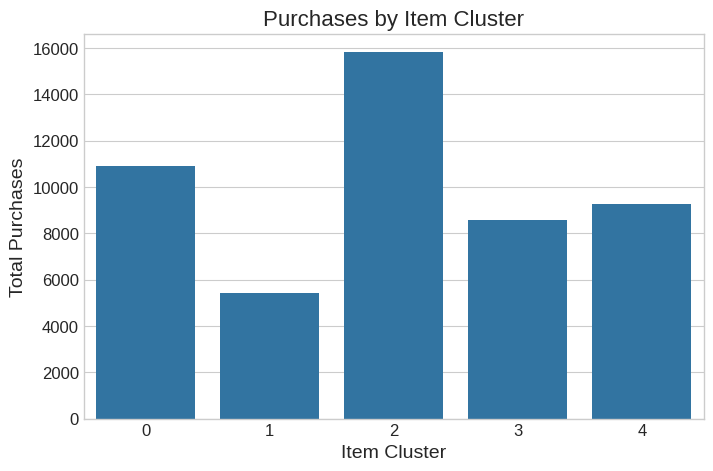

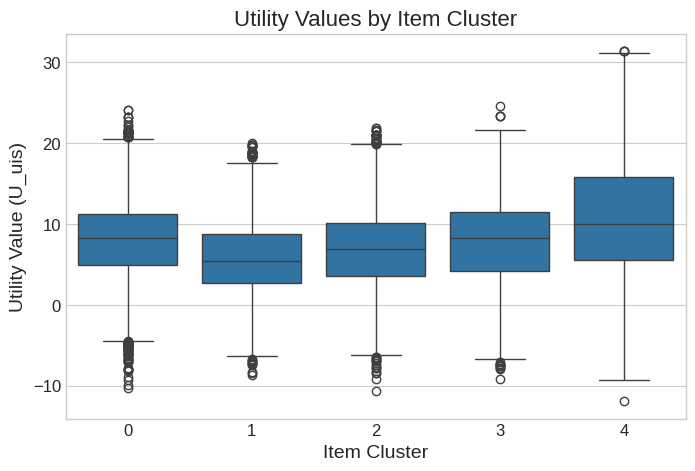

In [9]:
# Summary statistics for items chosen in the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set the style for plots
plt.style.use('seaborn-v0_8-whitegrid')  # Updated to use the new style name

# Count frequency of each item
item_counts = pd.Series(df_purchases['item'].values).value_counts()
item_percentages = 100 * item_counts / len(df_purchases)

# Create a dataframe for better visualization
item_stats = pd.DataFrame({
    'Count': item_counts,
    'Percentage': item_percentages
}).sort_index()

# Add summary statistics
print("Basic statistics for item choices:")
print(f"Total number of purchases: {len(df_purchases)}")
print(f"Number of unique items chosen: {len(item_counts)} out of {num_items} possible items")
print(f"Average purchases per item: {len(df_purchases) / num_items:.2f}")
print(f"Minimum purchases for an item: {item_counts.min()}")
print(f"Maximum purchases for an item: {item_counts.max()}")
print("\n")

# Most popular items
print("Top 10 most frequently chosen items:")
most_popular = item_stats.sort_values('Count', ascending=False).head(10)
print(most_popular)
print("\n")

# Least popular items
print("Top 10 least frequently chosen items:")
least_popular = item_stats.sort_values('Count').head(10)
print(least_popular)
print("\n")

# Visualize the distribution with a bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=item_stats.index, y='Count', data=item_stats)
plt.xlabel('Item ID')
plt.ylabel('Number of Purchases')
plt.title('Distribution of Item Purchases')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create a histogram of purchase counts
plt.figure(figsize=(10, 6))
sns.histplot(item_stats['Count'], bins=20, kde=True)
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Items')
plt.title('Histogram of Item Purchase Frequencies')
plt.show()

# Visualize relationship between item cluster and popularity
cluster_popularity = df_purchases.groupby('item_cluster')['item'].count().reset_index()
cluster_popularity.columns = ['Item Cluster', 'Total Purchases']

plt.figure(figsize=(8, 5))
sns.barplot(x='Item Cluster', y='Total Purchases', data=cluster_popularity)
plt.title('Purchases by Item Cluster')
plt.show()

# Create a DataFrame with the utility values
utility_data = pd.DataFrame({
    'item_cluster': df_purchases['item_cluster'],
    'U_uis': U_uis.flatten()  # Using U_uis instead of U_ui
})

# Check if certain utility values lead to more purchases
plt.figure(figsize=(8, 5))
sns.boxplot(x='item_cluster', y='U_uis', data=utility_data)
plt.title('Utility Values by Item Cluster')
plt.xlabel('Item Cluster')
plt.ylabel('Utility Value (U_uis)')
plt.show()

In [10]:
# Ignore UserWarning about y_pred values not summing to one
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The y_pred values do not sum to one")


MAX_EPOCHS = 500
records = []

for utility_formula, latent_dim in [
    ('alpha_user + beta_item', None),
    ('alpha_constant + beta_item', None),
    ('alpha_user + beta_item + gamma_user * delta_item', 2),
    ('alpha_user + beta_item + gamma_user * delta_item', 5),
    ('alpha_user + beta_item + gamma_user * delta_item', 10),
    ('alpha_user + beta_item + gamma_user * delta_item', 30),
]:
    bemb = LitBEMBFlex(
        model_optimizer="Adam",
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO, smaller number for faster training, more samples for better gradient estimation.
        utility_formula=utility_formula,
        num_users=num_users,
        num_items=num_items,
        trace_log_q=True,
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'alpha_user': False, 'alpha_constant': False,'beta_item': False, 'gamma_user': False, 'delta_item': False},
        # the dimension of beta_item, which is 1.
        coef_dim_dict={'alpha_user': 1, 'alpha_constant': 1, 'beta_item': 1, 'gamma_user': latent_dim, 'delta_item': latent_dim},
    )

    # use GPU if available.
    bemb = bemb.to(DEVICE)

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb, stats = bemb.fit_model(
        split_dataset_into_train_val_test(dataset_nonlinear),
        # full batch training.
        batch_size=len(dataset_nonlinear)//5, num_epochs=MAX_EPOCHS, num_workers=8, early_stopping_patience=3, device=DEVICE, enable_progress_bar=False, visualize_learning_curves=False)

    records.append((utility_formula, latent_dim, stats))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 3.1 K 
-----------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_user'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_user + beta_item
Total number of parameters: 3100.
With the following coefficients:
ModuleDict(
  (alpha_user): BayesianCoefficient(num_classes=1500, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[40000], session_index=[40000], item_availability=[], usersessionitem_obs=[50000, 6], device=cpu)
[Validation dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[5000], user_index=[5000], session_index=[5000], item_avai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 17.10723567008972
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.07020000368356705    │
│          test_ll          │    -3.6445910930633545    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 102   
-----------------------------------
102       Trainable params
0         Non-trainable params
102       Total params
0.000     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_constant'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_constant + beta_item
Total number of parameters: 102.
With the following coefficients:
ModuleDict(
  (alpha_constant): BayesianCoefficient(num_classes=1, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[40000], session_index=[40000], item_availability=[], usersessionitem_obs=[50000, 6], device=cpu)
[Validation dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[5000], user_index=[5000], session_index=[5000], i

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 38.598612785339355
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.0812000036239624     │
│          test_ll          │    -3.585561990737915     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 9.3 K 
-----------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_user'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None},
 {'coefficient': ['gamma_user', 'delta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_user + beta_item + gamma_user * delta_item
Total number of parameters: 9300.
With the following coefficients:
ModuleDict(
  (alpha_user): BayesianCoefficient(num_classes=1500, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
  (gamma_user): BayesianCoefficient(num_classes=1500, dimension=2, prior=N(0, I))
  (delta_item): BayesianCoefficient(num_classes=50, dimension=2, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[40000

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 99.23956871032715
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4115999937057495     │
│          test_ll          │    -2.181912422180176     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 18.6 K
-----------------------------------
18.6 K    Trainable params
0         Non-trainable params
18.6 K    Total params
0.074     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_user'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None},
 {'coefficient': ['gamma_user', 'delta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_user + beta_item + gamma_user * delta_item
Total number of parameters: 18600.
With the following coefficients:
ModuleDict(
  (alpha_user): BayesianCoefficient(num_classes=1500, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
  (gamma_user): BayesianCoefficient(num_classes=1500, dimension=5, prior=N(0, I))
  (delta_item): BayesianCoefficient(num_classes=50, dimension=5, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[4000

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 72.42848420143127
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5149999856948853     │
│          test_ll          │     -1.60585355758667     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 34.1 K
-----------------------------------
34.1 K    Trainable params
0         Non-trainable params
34.1 K    Total params
0.136     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_user'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None},
 {'coefficient': ['gamma_user', 'delta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_user + beta_item + gamma_user * delta_item
Total number of parameters: 34100.
With the following coefficients:
ModuleDict(
  (alpha_user): BayesianCoefficient(num_classes=1500, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
  (gamma_user): BayesianCoefficient(num_classes=1500, dimension=10, prior=N(0, I))
  (delta_item): BayesianCoefficient(num_classes=50, dimension=10, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[40

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 55.68675351142883
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5339999794960022     │
│          test_ll          │    -1.499263882637024     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 96.1 K
-----------------------------------
96.1 K    Trainable params
0         Non-trainable params
96.1 K    Total params
0.384     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_user'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None},
 {'coefficient': ['gamma_user', 'delta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_user + beta_item + gamma_user * delta_item
Total number of parameters: 96100.
With the following coefficients:
ModuleDict(
  (alpha_user): BayesianCoefficient(num_classes=1500, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
  (gamma_user): BayesianCoefficient(num_classes=1500, dimension=30, prior=N(0, I))
  (delta_item): BayesianCoefficient(num_classes=50, dimension=30, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[40

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 49.50252342224121
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5544000267982483     │
│          test_ll          │    -1.493821620941162     │
└───────────────────────────┴───────────────────────────┘

In [11]:
from typing import List, Tuple, Dict, Optional, Any
import matplotlib.pyplot as plt
import numpy as np
import re

def format_utility_formula(formula: str) -> str:
    """
    Convert utility formula to a prettier format with Greek letters.

    Args:
        formula: A utility formula string like 'alpha_user + beta_item'

    Returns:
        A formatted string with Greek letters and proper subscripts
    """
    # Define mapping of parameter names to Greek letters with subscripts
    greek_mapping = {
        'alpha_user': r'$\alpha_{user}$',
        'alpha_constant': r'$\alpha$',
        'alpha_item': r'$\alpha_{item}$',
        'beta_user': r'$\beta_{user}$',
        'beta_item': r'$\beta_{item}$',
        'gamma_user': r'$\gamma_{user}$',
        'gamma_item': r'$\gamma_{item}$',
        'delta_user': r'$\delta_{user}$',
        'delta_item': r'$\delta_{item}$',
        'theta_user': r'$\theta_{user}$',
        'eta_item': r'$\eta_{item}$',
        'pi_user': r'$\pi_{user}$',
    }

    # Replace parameter names with their Greek equivalents
    for param, greek in greek_mapping.items():
        formula = formula.replace(param, greek)

    # Format operators
    formula = formula.replace(' * ', ' · ')

    return formula

def visualize_model_results(
    records: List[Tuple[str, Optional[int], Dict[str, Any]]]
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Visualize the training, validation, and test results from multiple model configurations.
    Shows negative log-likelihood for validation and test metrics (lower is better for all plots).

    Args:
        records: List of tuples (utility_formula, latent_dim, stats) with model results

    Returns:
        Tuple containing (figure, axes) for further customization if needed
    """
    # Create descriptive labels for each model with Greek letter formatting
    model_labels = []
    for utility_formula, latent_dim, _ in records:
        formatted_formula = format_utility_formula(utility_formula)
        if latent_dim is None:
            model_labels.append(f"{formatted_formula}")
        else:
            model_labels.append(f"{formatted_formula} (dim={latent_dim})")

    # Color map for consistent colors across plots
    colors = plt.cm.tab10(np.linspace(0, 1, len(records)))

    # Create a single figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=300)

    # Subplot 1: Training ELBO by epochs
    for i, (_, _, stats) in enumerate(records):
        epochs = range(1, len(stats['train_elbo']) + 1)
        axes[0].plot(epochs, stats['train_elbo'], marker='o', markersize=4,
                     linewidth=0.8, color=colors[i], label=model_labels[i])

    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Training ELBO')
    axes[0].set_title('Training ELBO\n(lower is better)')
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Subplot 2: Negative Validation Log-Likelihood by epochs
    for i, (_, _, stats) in enumerate(records):
        epochs = range(1, len(stats['val_ll']) + 1)
        # Negate val_ll to show negative log-likelihood
        axes[1].plot(epochs, [-ll for ll in stats['val_ll']], marker='s', markersize=4,
                     linewidth=0.8, color=colors[i], label=model_labels[i])

    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Negative Validation Log-Likelihood')
    axes[1].set_title('Negative Validation Log-Likelihood\n(lower is better)')
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Subplot 3: Negative Test Log-Likelihood for each model
    # Negate test_ll to show negative log-likelihood
    test_neg_ll_values = [-stats['test_ll'].item() for _, _, stats in records]

    bars = axes[2].bar(range(len(model_labels)), test_neg_ll_values, color=colors, width=0.7)

    # Add value labels on top of bars
    for bar, val in zip(bars, test_neg_ll_values):
        height = bar.get_height()
        axes[2].annotate(f'{val:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=0)

    axes[2].set_xlabel('Model Configuration')
    axes[2].set_ylabel('Negative Test Log-Likelihood')
    axes[2].set_title('Negative Test Log-Likelihood\n(lower is better)')
    axes[2].set_xticks(range(len(model_labels)))
    axes[2].set_xticklabels(model_labels, rotation=45, ha='right')
    axes[2].grid(True, linestyle='--', alpha=0.7, axis='y')

    # Add a vertically stacked legend at the bottom
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',  # Position at the center
               bbox_to_anchor=(0.5, 0.30),  # Position below the plots
               ncol=1,  # Stack items vertically (one column)
               fancybox=True,
               shadow=True,
               frameon=True)

    plt.tight_layout()
    # Adjust bottom margin to make room for the vertically stacked legend
    plt.subplots_adjust(bottom=0.20 + 0.03*len(records))  # Scale based on number of items

    return fig, axes

(<Figure size 6000x1800 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'Training ELBO\n(lower is better)'}, xlabel='Epochs', ylabel='Training ELBO'>,
        <AxesSubplot: title={'center': 'Negative Validation Log-Likelihood\n(lower is better)'}, xlabel='Epochs', ylabel='Negative Validation Log-Likelihood'>,
        <AxesSubplot: title={'center': 'Negative Test Log-Likelihood\n(lower is better)'}, xlabel='Model Configuration', ylabel='Negative Test Log-Likelihood'>],
       dtype=object))

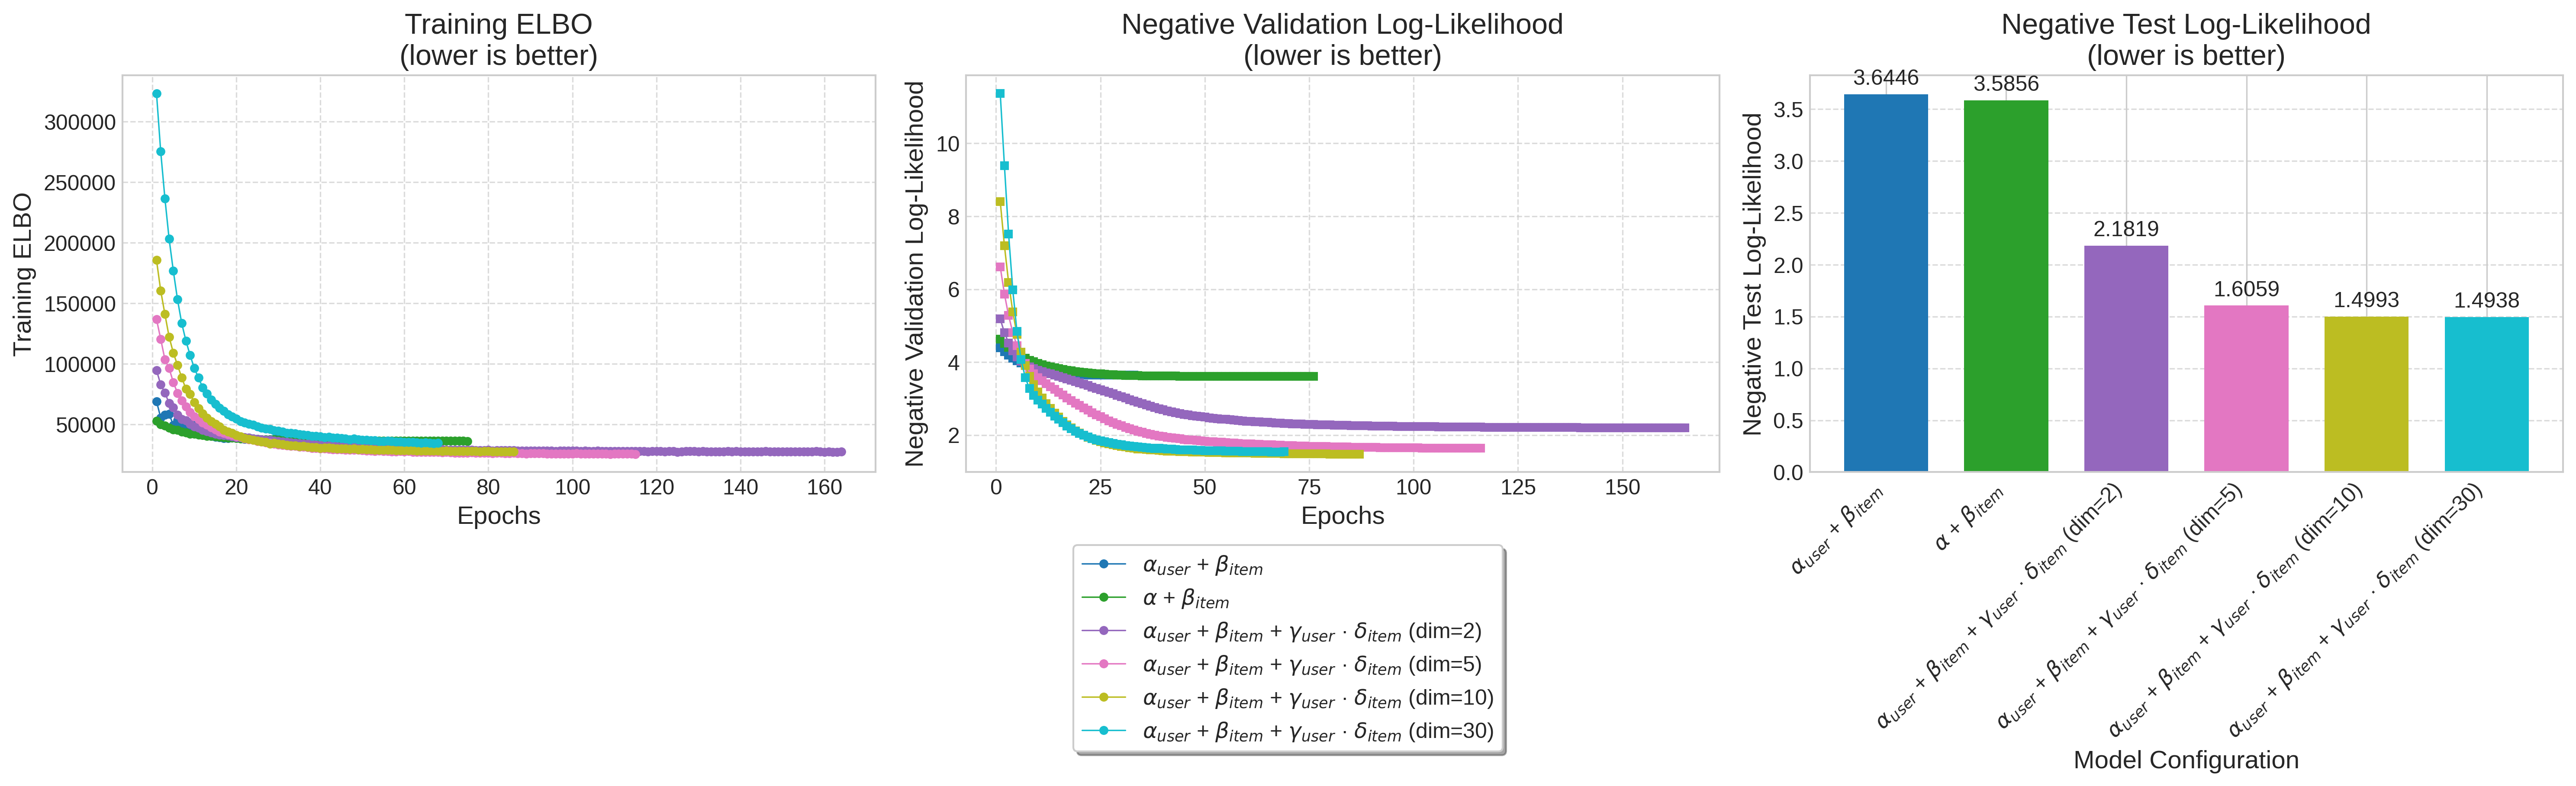

In [12]:
visualize_model_results(records=records)

# [[[JUMP HERE]]]

# Previous Simulation Studies.

In [7]:
# we assign random users and sessions to each choice record.
user_index = torch.LongTensor(np.random.choice(num_users, size=data_size))
session_index = torch.LongTensor(np.random.choice(num_sessions, size=data_size))

In [8]:
# a helper function to plot distributions of entries in a tensor.
def plot_tensor(tensor):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=DPI)
    sns.histplot(tensor.view(-1,).numpy(), bins=40, ax=ax)
    fig.show()

# Simulation Study 1: Item-Level "Random" Effect on User Attributes

## Simulate Dataset
We first specify the number of users and number of items in the dataset.
The `data_size` denotes the number of user-item choice pairs to generate (i.e., number of observations.)
Each user-item choice pair is called a **purchasing record** in our terminology, you can revise the data management tutorial.

In [ ]:
# generate random user income data.
user_income = (torch.randn(num_users) + 5).clamp(min=0)
# plot the histogram of user income.
plot_tensor(user_income)

In [ ]:
# generate item price data.
item_price = torch.rand(num_items) * 50 + 50
# plot distribution of item prices.
plot_tensor(item_price)
# WLOG, assign the first 25 items to be in the same category (category 1), and the rest to be in the other category (category 0).
item_bin_cate = torch.zeros(num_items).long()
item_bin_cate[:25] = 1

# combine both information into a tensor of shape (num_items, 2).
item_obs = torch.stack([item_price, item_bin_cate], dim=1)

## Generate Item-Specific Random Coefficients and Utilities.
In our first simulation case, the utility $\mu_{uis}$ is a function of user-income with item-specific coefficient.

$$
\mu_{uis} = \beta_i \times x^\text{user income}_u
$$

The item-specific coefficient $\beta_i$ is generated as a stochastic function of item prices. For high price items, income boost utility (e.g., luxury items). For low price items, low income boost utility. Please refer to the BEMB paper for a more detailed description of the simulation setup.

In [ ]:
# generate $beta_i$ for simulation study.
scaled_price = (item_price - torch.min(item_price))/ (torch.max(item_price) - torch.min(item_price)) - 0.5
beta_item = torch.randn_like(scaled_price)*torch.std(scaled_price) + scaled_price

# plot the relationship between $price_i$ and $beta_i$.
fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)
sns.regplot(x=item_price.squeeze().numpy(), y=beta_item.numpy(), ax=ax)
ax.set_xlabel("$price_i$")
ax.set_ylabel("$beta_i$")
fig.savefig(os.path.join(OUTPUT_DIR, 'simulation_1_income_coefficients.png'), dpi=DPI, bbox_inches='tight')
fig.show()

In [12]:
# compute the utility $\mu_{uis}$ for each user $u$, item $i$, and session $s$.
# there is no session effect in this simulation study, hence $\mu_{uis}$ is the same for all $s$.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in range(num_users):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = beta_item[i] * user_income[u]

In [ ]:
# distribution of U*I*S utility entries.
plot_tensor(utility)

## Generate Random Choices based on Utilities.

In [14]:
item_index = torch.empty(data_size, dtype=torch.long)
for idx in range(data_size):
    # get the user and session index corresponding to each choice record.
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]  # list of utility values for all items in the session.
    p = torch.softmax(utility_list, dim=0).numpy()  # soft-max transform utilities to probabilities in multinominal distribution.
    assert abs(np.sum(p) - 1) < 1e-5  # check if the sum of probabilities is 1.
    # randomly choose an item from the multinominal distribution with probabilities p.
    item_index[idx] = np.random.choice(num_items, p=p)

In [15]:
def report_most_least_bought_items(item_index: torch.LongTensor):
    # report most bought and least bought items.
    vc = pd.DataFrame(data={"item": item_index.squeeze().numpy()}).value_counts(normalize=True).sort_values(ascending=False)
    print("Most bought item with their frequencies:")
    print(vc.head())
    print("Least bought item with their frequencies:")
    print(vc.tail())

## Build Choice Dataset
Please refer to our `torch-choice` paper for more details.

In [16]:
def split_dataset_into_train_val_test(D: ChoiceDataset) -> List[ChoiceDataset]:
    # split dataset into train, val, test.
    idx = np.random.permutation(len(D))
    train_size = int(0.8 * len(D))
    val_size = int(0.1 * len(D))
    train_idx = idx[:train_size]
    val_idx = idx[train_size: train_size + val_size]
    test_idx = idx[train_size + val_size:]

    dataset_list = [D[train_idx], D[val_idx], D[test_idx]]
    return dataset_list

In [ ]:
dataset_1 = ChoiceDataset(user_index=user_index,
                        item_index=item_index,
                        session_index=session_index,
                        item_availability=None,  # everything is available.
                        # observables.
                        user_income=user_income.view(num_users, 1),
                        item_price=item_price.view(num_items, 1),
                        item_bin_cate=item_bin_cate).to(DEVICE)

print(dataset_1)

## Fit A Model

In [ ]:
# def fit_model(obs2prior: bool):
LATENT_DIM = 10  # the dimension of alpha and theta.
bemb = LitBEMBFlex(
    model_optimizer="Adam",
    learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
    pred_item=True,  # let the model predict item_index, don't change this one.
    num_seeds=128,  # number of Monte Carlo samples for estimating the ELBO.
    utility_formula='beta_item * user_income',  # the utility formula.
    num_users=num_users,
    num_items=num_items,
    trace_log_q=True,
    # whether to turn on obs2prior for each parameter.
    obs2prior_dict={'beta_item': False},
    # the dimension of beta_item, which is 1.
    coef_dim_dict={'beta_item': 1},
)

# use GPU if available.
bemb = bemb.to(DEVICE)

# use the provided run helper to train the model.
# we set batch size to be 5% of the data size, and train the model for 10 epochs.
# there would be 20*10=200 gradient update steps in total.
bemb = bemb.fit_model(
    split_dataset_into_train_val_test(dataset_1),
    batch_size=256, num_epochs=3, num_workers=0, device=DEVICE, enable_progress_bar=False)

## Comparison between $\beta_i$ and $\hat{\beta}_i$ for items.

In [ ]:
# actual beta_i's
real = beta_item.squeeze().numpy()
# prediction from the fitted variational distribution.
pred = bemb.state_dict()["coef_dict.beta_item.variational_mean_flexible"].squeeze().numpy()
err = 1.96 * bemb.state_dict()["coef_dict.beta_item.variational_logstd"].squeeze().exp()

print(f"{real.shape=:}, {pred.shape=:}")
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
ax.scatter(np.arange(num_items), real, label="beta", marker="o", color="blue")
ax.errorbar(np.arange(num_items), y=pred, yerr=err, label="beta-hat", marker="x", linestyle='none', color="orange")

ax.set_xlabel("Item Index")
ax.set_ylabel("Real and Estimated Coefficients")
ax.legend()
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_1_beta_hat.png"), dpi=DPI, bbox_inches="tight")
fig.show()

# Simulation Study 2: More Complicated Item-Specific Effects (Obs2Prior)

In [ ]:
# modify the beta_item based on the item category.
for i in range(num_items):
    if item_bin_cate[i] == 1:
        beta_item[i] = beta_item[i] + 3

fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)
sns.regplot(x=item_price.squeeze().numpy(), y=beta_item.numpy(), ax=ax)
ax.set_xlabel("$price_i$")
ax.set_ylabel("$beta_i$")
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_2_income_coefficients.png"), dpi=DPI, bbox_inches='tight')
fig.show()

In [ ]:
# recompute the utility matrix using the new coefficient.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in tqdm(range(num_users)):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = beta_item[i] * user_income[u]
# generate choices.
item_index = torch.empty(data_size, dtype=torch.long)
for idx in tqdm(range(data_size)):
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]
    p = torch.softmax(utility_list, dim=0).numpy()
    item_index[idx] = np.random.choice(num_items, p=p)

In [ ]:
report_most_least_bought_items(item_index)

In [23]:
dataset_2 = ChoiceDataset(user_index=user_index,
                        item_index=item_index,
                        session_index=session_index,
                        item_availability=None,  # everything is available.
                        # observables.
                        user_income=user_income.view(num_users, 1),
                        item_price=item_price.view(num_items, 1),
                        item_bin_cate=item_bin_cate.view(num_items, 1),
                        item_obs=item_obs
                        ).to(DEVICE)

In [ ]:
# run two versions of the model with and without obs2prior.
for enable_obs2prior in [True, False]:
    # def fit_model(obs2prior: bool):
    LATENT_DIM = 10  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        model_optimizer="Adam",
        learning_rate=0.3,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='beta_item * user_income',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        trace_log_q=True,
        # num_user_obs=dataset.user_obs.shape[1],
        num_item_obs=dataset_2.item_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'beta_item': enable_obs2prior},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'beta_item': 1},
    )

    # use GPU if available.
    bemb = bemb.to(DEVICE)

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_2),
                          batch_size=128, num_epochs=40, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # plot the coefficients.
    real = beta_item.squeeze().numpy()
    pred = bemb.state_dict()["coef_dict.beta_item.variational_mean_flexible"].squeeze().numpy()
    err = 1.96 * bemb.state_dict()["coef_dict.beta_item.variational_logstd"].squeeze().exp()

    print(f"{real.shape=:}, {pred.shape=:}")
    fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
    ax.scatter(np.arange(num_items), real, label="beta", marker="o")
    ax.scatter(np.arange(num_items), pred, label="beta-hat", marker="x")
    ax.errorbar(np.arange(num_items), y=pred, yerr=err, label="beta-hat", marker="x", linestyle='none', color="orange")
    ax.set_xlabel("Item Index")
    ax.set_ylabel("Real and Estimated Coefficients")
    ax.legend()

    if enable_obs2prior:
        ax.set_title("Item-Specific Coefficients with Obs2Prior")
    else:
        ax.set_title("Item-Specific Coefficients without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_2_beta_hat_obs2prior={enable_obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

# Simulation Study 3: User Latent and Item Latent Interactions

## User Specific Preferences

In [ ]:
Is = np.sin(np.arange(int(0.8*num_users)) / num_users * 4 * np.pi)
Is = (Is + 1) / 2 * num_items
Is = Is.astype(int)

Us = np.arange(num_users)
Is = np.concatenate([
    np.arange(int(0.2*num_users)) * num_items / (0.2*num_users),
    Is
])

PREFERENCE = dict((u, i) for (u, i) in zip(Us, Is))

# plot the preference
fig, ax = plt.subplots(figsize=(8, 3), dpi=DPI)
ax.scatter(Us, Is, s=0.3)
ax.set_xlabel('User Index')
ax.set_ylabel('Item Index $i^{like}(u)$')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_3_user_preferences.png"), dpi=DPI, bbox_inches='tight')
fig.show()

In [26]:
item_index = torch.LongTensor(np.random.choice(num_items, size=data_size))
user_bin_cate = torch.zeros(num_users).long()
# group users into two categories.
user_bin_cate[:100] = 1
user_bin_cate[200:num_users // 2] = 1

for idx in range(data_size):
    # follows random behaviors.
    rnd = np.random.rand()
    if user_bin_cate[int(user_index[idx])] == 0:
        if rnd <= 0.5:
            # choose based on preference with a probability of 0.5.
            item_index[idx] = PREFERENCE[int(user_index[idx])]
    else:
        if rnd <= 0.5:
            # choose based on preference with a probability of 0.5.
            item_index[idx] = num_items - PREFERENCE[int(user_index[idx])] - 1

To have a visual inspection on the preference we added, we can plot a heat map indexed by (user, item) and visualize the frequency of bought items by each user. In the heat map below, each row represents the empirical distribution of items (x-axis) bought. Warmer color (red) indicates high purchasing frequencies, which shows the synthetic sin-curve of preference we enforced above.

In [ ]:
df = pd.DataFrame(data={'item': item_index, 'user': user_index}).groupby(['item', 'user']).size().rename('size').reset_index()
df = df.pivot('item', 'user', 'size').fillna(0.0)

fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(df.values, square=False, ax=ax, cmap='coolwarm')
ax.set(xlabel='User Index', ylabel='Item Selected')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_3_heatmap.png"), dpi=DPI, bbox_inches="tight")
fig.show()

In [ ]:
# user_obs = torch.eye(num_users)
# user_obs = user_bin_cate.view(-1, 1)
# user_obs = torch.zeros(num_users, num_items)
# for u in range(num_users):
#     x = int(PREFERENCE[u])
#     if user_bin_cate[u] == 0:
#         user_obs[u, x] = 1
#     else:
#         user_obs[u, num_items - x - 1] = 1
# user_obs[torch.arange(num_users), Is] = 1
dataset_3 = ChoiceDataset(user_index=user_index, item_index=item_index, user_obs=torch.eye(num_users))

In [29]:
def fit_model(obs2prior: bool):
    LATENT_DIM = 5  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='theta_user * alpha_item',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        num_user_obs=dataset_3.user_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'theta_user': obs2prior, 'alpha_item': False},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'theta_user': LATENT_DIM, 'alpha_item': LATENT_DIM}
    )

    # use GPU if available.
    if torch.cuda.is_available():
        bemb = bemb.to('cuda')

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_3),
                          batch_size=128, num_epochs=100, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # visualize the prediction.
    T = bemb.model.coef_dict['theta_user'].variational_mean_flexible.data
    A = bemb.model.coef_dict['alpha_item'].variational_mean_flexible.data
    fig, ax = plt.subplots(figsize=(18, 3))
    sns.heatmap((A @ T.T).numpy(), square=False, ax=ax, cmap='coolwarm')
    if obs2prior:
        ax.set_title("User-Item Interaction Utility with Obs2Prior")
    else:
        ax.set_title("User-Item Interaction Utility without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_3_interaction_hat_obs2prior={obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

In [ ]:
fit_model(obs2prior=True)

In [ ]:
fit_model(obs2prior=False)

# Simulation Study 4: User Latent and Item Latent Coefficient

In [32]:
magnitude = 5
theta = torch.empty(num_users, num_items)
for u in range(num_users):
    for i in range(num_items):
        diff = np.abs(i - (PREFERENCE[u])) / 100
        theta[u, i] = 1/(1 + np.exp(-diff))
        theta[u, i] = magnitude * theta[u, i] - 2.8

In [ ]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(theta.T, square=False, ax=ax, cmap='coolwarm')
ax.set(xlabel='User Index', ylabel='Item Index')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_4_coefficients.png"), dpi=DPI, bbox_inches="tight")
fig.show()

In [34]:
# generate random session observables.
session_obs = (torch.randn(num_sessions) + 1) * 100

In [ ]:
# recompute utilities.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in tqdm(range(num_users)):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = theta[u, i] * session_obs[s]

# sample random choices as before.
item_index = torch.empty(data_size, dtype=torch.long)
for idx in tqdm(range(data_size)):
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]
    p = torch.softmax(utility_list, dim=0).numpy()
    item_chosen = np.random.choice(num_items, p=p)
    item_index[idx] = item_chosen

# report most bought and least bought items.
report_most_least_bought_items(item_index)

In [36]:
user_obs = torch.zeros(num_users, num_items)
user_obs[torch.arange(num_users), Is] = 1

In [37]:
dataset_4 = ChoiceDataset(
    user_index=user_index,
    item_index=item_index,
    user_obs=user_obs,
    item_obs=item_obs,
    session_index=session_index,
    session_obs=session_obs.view(num_sessions, 1))

In [38]:
def fit_model(obs2prior: bool):
    LATENT_DIM = 5  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='theta_user * alpha_item * session_obs',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        num_sessions=num_sessions,
        num_user_obs=dataset_4.user_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'theta_user': obs2prior, 'alpha_item': False},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'theta_user': LATENT_DIM, 'alpha_item': LATENT_DIM}
    ).to(DEVICE)

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_4),
                          batch_size=128, num_epochs=300, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # visualize the prediction.
    T = bemb.model.coef_dict['theta_user'].variational_mean_flexible.data
    A = bemb.model.coef_dict['alpha_item'].variational_mean_flexible.data
    fig, ax = plt.subplots(figsize=(18, 3))
    sns.heatmap((A @ T.T).numpy(), square=False, ax=ax, cmap='coolwarm')
    if obs2prior:
        ax.set_title("User-Item Interaction Utility with Obs2Prior")
    else:
        ax.set_title("User-Item Interaction Utility without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_4_interaction_hat_obs2prior={obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

In [ ]:
fit_model(obs2prior=True)